# Effect Classification

In [1]:
import torch
import torchaudio
import os

#### Add Tensorboard to record data

In [2]:
from torch.utils.tensorboard import SummaryWriter

EXPERIMENT_NAME = "c53_classify"
LOG_DIR = "_log/" + EXPERIMENT_NAME
EVU_DIR = "_log/Evaluation/"

if not os.path.exists('%s' % LOG_DIR):
    os.makedirs('%s' % LOG_DIR)

if not os.path.exists('%s' % EVU_DIR):
    os.makedirs('%s' % EVU_DIR)

log_writer = SummaryWriter(LOG_DIR)


### Load dataset

Using device cpu
There are 391500 samples in the dataset.
Shape of signal: torch.Size([1, 64, 64])
input feature:


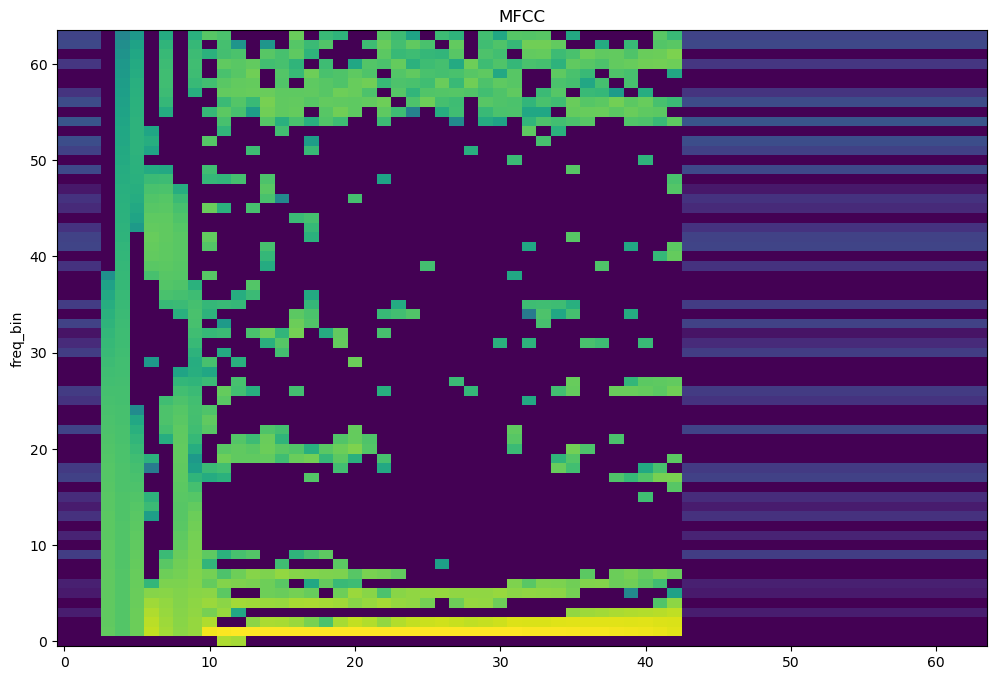

In [3]:
from src.gtfxdataset import GtFxDataset
from src.util import plot_spectrogram

AUDIO_DIR = "_assets/DATASET/GT-FX-C53/"
ANNOTATIONS_FILE = os.path.join(AUDIO_DIR, "annotation.csv")

SAMPLE_RATE = 22050
NUM_SAMPLES = 22050*3

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(f"Using device {device}")

mfcc = torchaudio.transforms.MFCC(
    sample_rate = SAMPLE_RATE, 
    n_mfcc = 64,
    melkwargs = {
        "n_fft": 1024,
        "hop_length": 1024,
        "n_mels": 64,
        "center": False})

fxData = GtFxDataset(ANNOTATIONS_FILE,
                        AUDIO_DIR,
                        mfcc,
                        SAMPLE_RATE,
                        NUM_SAMPLES,
                        device)

signal, _, _, _, filename = fxData[0]
print(f"There are {len(fxData)} samples in the dataset.")
print(f"Shape of signal: {signal.shape}")

print("input feature:")
log_writer.add_figure("Input Feature", plot_spectrogram(signal[0], title="MFCC"))

#### Split dataset into train and test sets

In [4]:
from src.classifier import train

BATCH_SIZE = round(len(fxData) / 1500)

split_ratio = [0.8, 0.1, 0.1]
train_set, test_set, val_set = torch.utils.data.random_split(fxData, lengths=split_ratio)

train_dataloader = train.create_data_loader(train_set, BATCH_SIZE)
test_dataloader = train.create_data_loader(test_set, BATCH_SIZE)
val_dataloader = train.create_data_loader(val_set, BATCH_SIZE)

#### Model training

In [5]:
from src.classifier import model
from torch import nn

LEARNING_RATE = 0.001
EPOCHS = 15

WEIGHTS_DIR = "_weights/"
WEIGHTS_PATH = os.path.join(WEIGHTS_DIR, EXPERIMENT_NAME)

if not os.path.exists('%s' % WEIGHTS_DIR):
    os.makedirs('%s' % WEIGHTS_DIR)

# construct model and assign it to device
cnn = model.Classifier().to(device)

log_writer.add_graph(cnn, signal.unsqueeze_(0))

# initialise loss funtion + optimiser
loss_fn = nn.BCEWithLogitsLoss()
optimiser = torch.optim.Adam(cnn.parameters(), lr=LEARNING_RATE)

# train model
train.train(cnn,
            train_dataloader,
            test_dataloader,
            loss_fn,
            optimiser,
            device,
            log_writer,
            EPOCHS,
            WEIGHTS_PATH)


c:\Users\roger\miniconda3\envs\torchaudio\lib\site-packages\torch\jit\_trace.py:1056: TracerWarning: Encountering a list at the output of the tracer might cause the trace to be incorrect, this is only valid if the container structure does not change based on the module's inputs. Consider using a constant container instead (e.g. for `list`, use a `tuple` instead. for `dict`, use a `NamedTuple` instead). If you absolutely need this and know the side effects, pass strict=False to trace() to allow this behavior.
  module._c._create_method_from_trace(


Epoch 1
loss: 3.531365  [  0/313200]
loss: 2.432594  [5220/313200]
loss: 1.953130  [10440/313200]
loss: 1.519835  [15660/313200]
loss: 1.307574  [20880/313200]
loss: 1.296066  [26100/313200]
loss: 1.123210  [31320/313200]
loss: 1.235636  [36540/313200]
loss: 1.059916  [41760/313200]
loss: 0.942105  [46980/313200]
loss: 0.903043  [52200/313200]
loss: 0.734513  [57420/313200]
loss: 0.829132  [62640/313200]
loss: 0.763060  [67860/313200]
loss: 0.659367  [73080/313200]
loss: 0.734758  [78300/313200]
loss: 0.741771  [83520/313200]
loss: 0.858810  [88740/313200]
loss: 0.631795  [93960/313200]
loss: 0.687953  [99180/313200]
loss: 0.478164  [104400/313200]
loss: 0.686311  [109620/313200]
loss: 0.501843  [114840/313200]
loss: 0.471037  [120060/313200]
loss: 0.442177  [125280/313200]
loss: 0.545287  [130500/313200]
loss: 0.503398  [135720/313200]
loss: 0.581457  [140940/313200]
loss: 0.342131  [146160/313200]
loss: 0.347388  [151380/313200]
loss: 0.394834  [156600/313200]
loss: 0.419887  [161820

KeyboardInterrupt: 

#### Evaluation

[[18160     0]
 [    6 20984]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18160
           1       1.00      1.00      1.00     20990

    accuracy                           1.00     39150
   macro avg       1.00      1.00      1.00     39150
weighted avg       1.00      1.00      1.00     39150



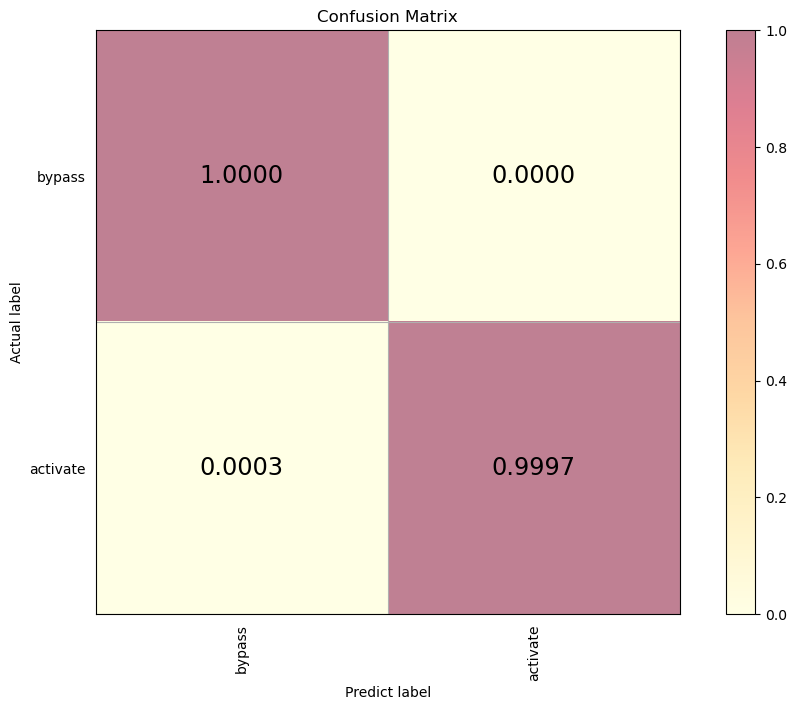

[[18076    21]
 [   34 21019]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18097
           1       1.00      1.00      1.00     21053

    accuracy                           1.00     39150
   macro avg       1.00      1.00      1.00     39150
weighted avg       1.00      1.00      1.00     39150



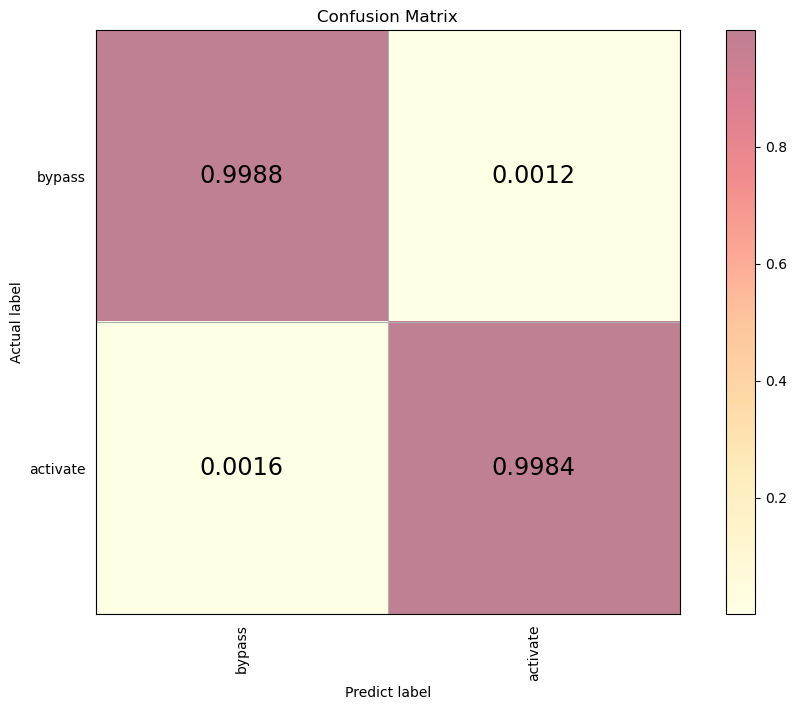

[[18063   181]
 [   54 20852]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     18244
           1       0.99      1.00      0.99     20906

    accuracy                           0.99     39150
   macro avg       0.99      0.99      0.99     39150
weighted avg       0.99      0.99      0.99     39150



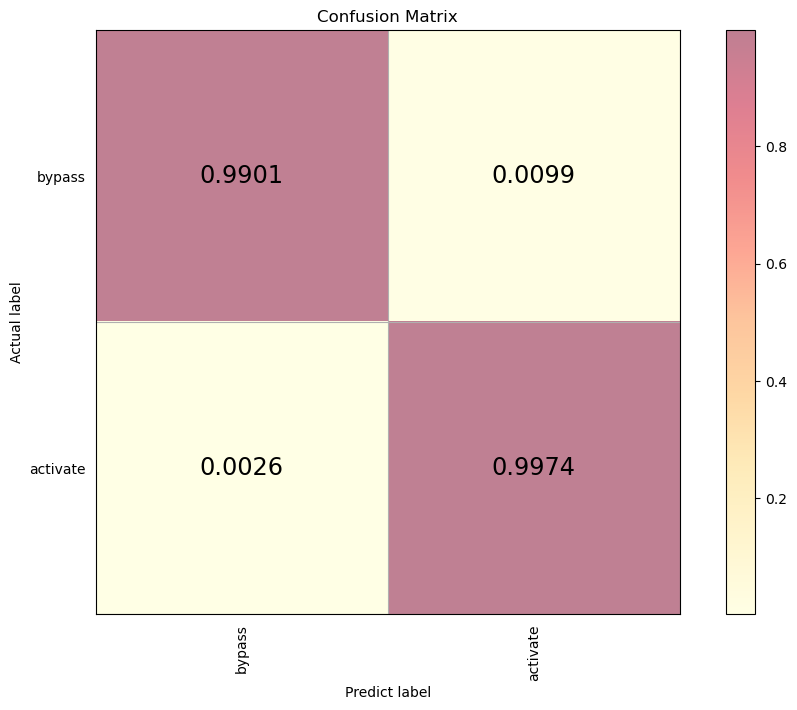

[[18091     6]
 [   11 21042]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18097
           1       1.00      1.00      1.00     21053

    accuracy                           1.00     39150
   macro avg       1.00      1.00      1.00     39150
weighted avg       1.00      1.00      1.00     39150



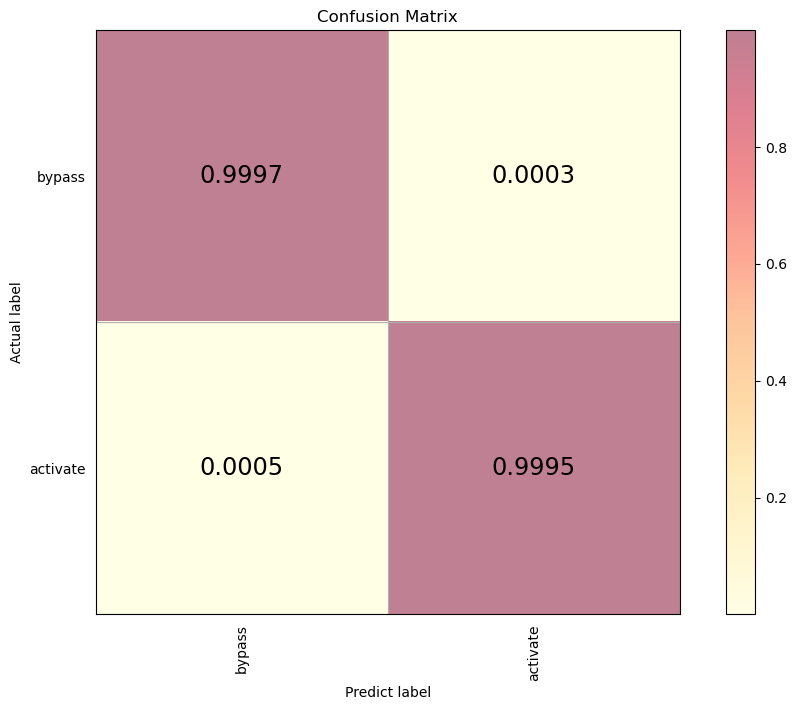

[[18116     2]
 [    2 21030]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18118
           1       1.00      1.00      1.00     21032

    accuracy                           1.00     39150
   macro avg       1.00      1.00      1.00     39150
weighted avg       1.00      1.00      1.00     39150



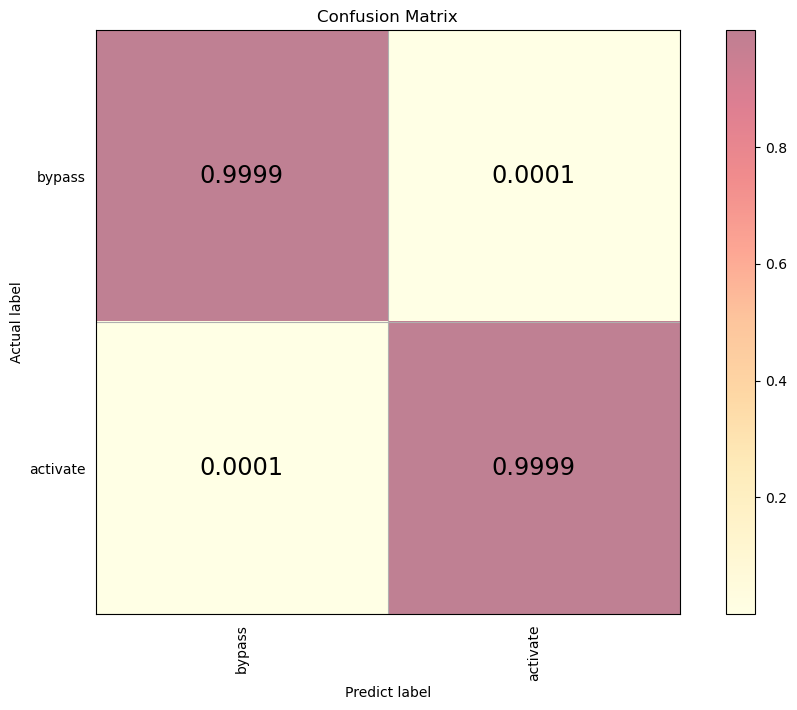

In [9]:
from sklearn.metrics import confusion_matrix, classification_report
from src.util import plot_confusion_matrix
import numpy as np

labels_ID = ['bypass', 'activate']
EFFECT_MAP = ["distortion", "chorus", "tremolo", "delay", "reverb"]

cnn = model.Classifier().to(device)

state_dict = torch.load(WEIGHTS_PATH + "_15.pth")
cnn.load_state_dict(state_dict)

_, _, log = train.test(cnn, val_dataloader, device)

for i in range(5):
    expected = []
    predicted = []
    for index, data in enumerate(log[i]):
        predicted.append(data[1])
        expected.append(data[2])

    arr = np.array([predicted, expected])
    np.save(EVU_DIR + EXPERIMENT_NAME + "_" + str(i) + "_evaluation.npy", arr)
    
    mat_con = confusion_matrix(y_true=expected, y_pred=predicted)
    print(mat_con)
    print(classification_report(expected, predicted))
    
    log_writer.add_figure("Confusion Matrix/" + EFFECT_MAP[i],
                          plot_confusion_matrix(mat_con, title='Confusion Matrix', classes=labels_ID))

log_writer.close()